# Comparing Bayesian Approaches to Disjoint Linear Bandits - NormalInverseGammaRegressor vs BayesianGLM

Linear bandits are useful for solving problems where the reward is a linear function of the context. In this notebook, we'll explore two different Bayesian approaches to linear contextual bandits by implementing variations of the disjoint LinUCB algorithm from [1]:

1. **NormalInverseGammaRegressor**: Provides exact Bayesian inference with conjugate priors but assumes Gaussian outcomes
2. **BayesianGLM**: More accurately models binary outcomes using logistic regression but relies on Laplace approximation for inference

We'll simulate a situation very similar to the one described in the paper, where we have a set of users with some known context, and a set of articles that we want to recommend to them. We can represent what we know about the users as the context to a multi-armed bandit problem, and the articles as the arms. The reward for each arm is the click-through rate (CTR) of that article for that user.

This comparison will highlight the trade-offs between **exact Bayesian inference** (NormalInverseGammaRegressor) and **more accurate likelihood modeling** (BayesianGLM) in contextual bandit settings.

[1] Lihong Li, Wei Chu, John Langford, and Robert E. Schapire. A contextual-bandit approach to personalized news article recommendation. Proceedings of the 19th international conference on World Wide Web, pages 661–670. ACM, 2010.

In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy.special import expit

rng = np.random.default_rng(123)

class ClickthroughOracle:
    def __init__(self):
        self.context = None
        self.rewards = []  # bernoulli outcome of the clickthrough
        self.optimal_rewards = []  # p of the optimal article for the given context
        self.expected_rewards = []  # p of the article chosen for the given context

        self.article_coefs = np.array(
            [
                [-0.4, 0.005, 0.1],
                [-0.8, 0.0, 0.0],
                [-0.3, -0.005, 0.0],
                [0.1, 0.0, -0.5],
            ]
        )

    def set_context(self, context: NDArray[np.float64]):
        # the context will consist of a numerical age column,
        # a one-hot encoded gender column.
        self.context = context

    def generate_reward(self, _coef: NDArray[np.float64]) -> int:
        p = expit(np.dot(self.context, _coef))
        reward = rng.binomial(1, p)
        self.rewards.append(reward)
        self.expected_rewards.append(p)
        return reward

    def best_expected_reward(self):
        self.optimal_rewards.append(
            np.max(expit(np.dot(self.context, self.article_coefs.T)))
        )

    def article_1(self):
        # article that really appeals to older men
        return self.generate_reward(self.article_coefs[0])

    def article_2(self):
        # article that nobody really likes
        return self.generate_reward(self.article_coefs[1])

    def article_3(self):
        # article that younger people like, but is equally enjoyed by any gender
        return self.generate_reward(self.article_coefs[2])

    def article_4(self):
        # article that women of all ages like
        return self.generate_reward(self.article_coefs[3])


oracle = ClickthroughOracle()


## Approach 1: NormalInverseGammaRegressor (Exact Bayesian Inference)

We want to use the Bayesian version of LinUCB to recommend articles to users. This is done, in part, by setting the underlying model to be a Bayesian linear regression model. We'll use the `NormalInverseGammaRegressor` class to do this. 

The default constructor arguments for `NormalInverseGammaRegressor` will give us a prior that is a normal distribution with mean 0 and variance 1, which corresponds to a ridge regression model. This is actually a problem for our use case, as our rewards will be either 0 or 1. There are a number of ways we can fix this, but the simplest is to center the rewards at 0 by subtracting 0.5 from them.

**Key characteristics:**
- **Exact Bayesian inference**: Uses conjugate Normal-Inverse-Gamma priors for closed-form posterior updates
- **Gaussian assumption**: Assumes rewards are normally distributed around the linear predictor
- **Fast computation**: No iterative optimization required
- **Trade-off**: Model mismatch since click-through is binary, not Gaussian

We can also set the `lam` parameter to 4, which corresponds to the ridge regression parameter `alpha` in scikit-learn. This regularizes the model coefficients more strongly toward 0, which is useful as we know that they are unlikely to be greater than or less than 1.

Additionally, we'll set our choice policy to be the `upper_confidence_bound` policy, which will choose the arm with the highest upper confidence bound. We'll also set the `alpha` parameter to be 0.80, somewhat arbitrarily. This parameter controls the trade-off between exploration and exploitation. A higher value of `alpha` will lead to more exploration, and a lower value will lead to more exploitation.

### Setting up the NormalInverseGammaRegressor approach

Next, we'll define our action space and reward function. The action space will be the set of articles, and the reward function will be whether or not the user clicked on the article.

Next, we'll define our action space and reward function. The action space will be the set of articles, and the reward function will be whether or not the user clicked on the article.

In [2]:
from enum import Enum

class Article(Enum):
    article_1 = 1
    article_2 = 2
    article_3 = 3
    article_4 = 4

    def take_action(self, oracle: ClickthroughOracle):
        if self == Article.article_1:
            return oracle.article_1()
        elif self == Article.article_2:
            return oracle.article_2()
        elif self == Article.article_3:
            return oracle.article_3()
        elif self == Article.article_4:
            return oracle.article_4()
        else:
            raise ValueError("invalid param")

Next, we'll create our arms using NormalInverseGammaRegressor. Linear bandits are inherently contextual, so we'll need to use the `ContextualAgent` class.

In [3]:
from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    ContextualAgent,
    UpperConfidenceBound
)

# Create arms using NormalInverseGammaRegressor for exact Bayesian inference
normal_arms = [
    Arm(Article.article_1, learner=NormalInverseGammaRegressor(lam=10.0)),
    Arm(Article.article_2, learner=NormalInverseGammaRegressor(lam=10.0)),
    Arm(Article.article_3, learner=NormalInverseGammaRegressor(lam=10.0)),
    Arm(Article.article_4, learner=NormalInverseGammaRegressor(lam=10.0)),
]

### Running NormalInverseGammaRegressor with UCB

Let's run the bandit for 10000 iterations, and see how well it does. We'll plot the cumulative reward over time to visualize how quickly the bandit learns to recommend the best article for each user.

Note that this step can be slow, depending on the number of samples being used to estimate the posterior. If you want to speed things up, you can reduce the number of samples used to estimate the posterior by setting the `samples` parameter in the `UpperConfidenceBound` object. This highlights the connection between Thompson sampling and the UCB algorithm - both are strategies that bake the uncertainty of the posterior into the point estimate of the reward used to choose the arm. In the limiting case where the number of samples is 1, the UCB algorithm reduces to Thompson sampling.

In [4]:
normal_ucb_agent = ContextualAgent(
    arms=normal_arms,
    policy=UpperConfidenceBound(0.95),
    random_seed=rng,
)


for _ in range(10000):

    user_gender = rng.binomial(1, 0.5) # 0 corresponds to female
    user_age = rng.integers(0, 47) # 0 corresponds to age 18

    context = np.array([1.0, user_age, user_gender])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = normal_ucb_agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    normal_ucb_agent.update(np.atleast_2d(context), np.array([oracle.rewards[-1] - 0.5]))

## Approach 2: BayesianGLM (Accurate Likelihood Modeling)

While the NormalInverseGammaRegressor approach works well, it makes a fundamental assumption that doesn't match our problem: it assumes the outcomes are Gaussian when they're actually binary (0 or 1 for click/no-click).

The `BayesianGLM` class provides a more principled approach by using **logistic regression** to model binary outcomes. However, this comes at the cost of exact Bayesian inference - we must rely on the **Laplace approximation** to approximate the posterior distribution of the coefficients.

**Key characteristics:**
- **Accurate likelihood**: Uses logistic regression for binary outcomes, matching the true data generating process
- **Laplace approximation**: Approximates the posterior with a multivariate normal distribution centered at the MAP estimate
- **Slower computation**: Requires iterative optimization to find the MAP estimate
- **Trade-off**: More accurate model but approximate inference

Let's compare how BayesianGLM performs on the same problem. We don't need to center the rewards since logistic regression naturally handles binary outcomes.

In [5]:
from bayesianbandits import BayesianGLM

# Create arms using BayesianGLM for more accurate likelihood modeling
glm_arms_ucb = [
    Arm(Article.article_1, learner=BayesianGLM(alpha=10.0, link='logit')),
    Arm(Article.article_2, learner=BayesianGLM(alpha=10.0, link='logit')),
    Arm(Article.article_3, learner=BayesianGLM(alpha=10.0, link='logit')),
    Arm(Article.article_4, learner=BayesianGLM(alpha=10.0, link='logit')),
]

glm_arms_thompson = [
    Arm(Article.article_1, learner=BayesianGLM(alpha=10.0, link='logit')),
    Arm(Article.article_2, learner=BayesianGLM(alpha=10.0, link='logit')),
    Arm(Article.article_3, learner=BayesianGLM(alpha=10.0, link='logit')),
    Arm(Article.article_4, learner=BayesianGLM(alpha=10.0, link='logit')),
]

### Running BayesianGLM with UCB

Let's run the BayesianGLM approach with UCB policy and compare its performance:

In [6]:
# Create a new oracle for BayesianGLM UCB experiment
glm_ucb_oracle = ClickthroughOracle()

glm_ucb_agent = ContextualAgent(
    arms=glm_arms_ucb,
    policy=UpperConfidenceBound(0.95),
    random_seed=rng,
)


for _ in range(10000):
    user_gender = rng.binomial(1, 0.5) # 0 corresponds to female
    user_age = rng.integers(0, 47) # 0 corresponds to age 18

    context = np.array([1.0, user_age, user_gender])

    glm_ucb_oracle.set_context(context)
    glm_ucb_oracle.best_expected_reward()

    action, = glm_ucb_agent.pull(np.atleast_2d(context))
    action.take_action(glm_ucb_oracle)
    # Note: No need to center rewards for BayesianGLM
    glm_ucb_agent.update(np.atleast_2d(context), np.array([glm_ucb_oracle.rewards[-1]]))

We can see that both agents quickly learn to recommend reasonably good articles per user, and clearly achieve sublinear regret, though in this specific instantiation, the BayesianGLM agent learns slightly faster than the NormalInverseGammaRegressor agent.

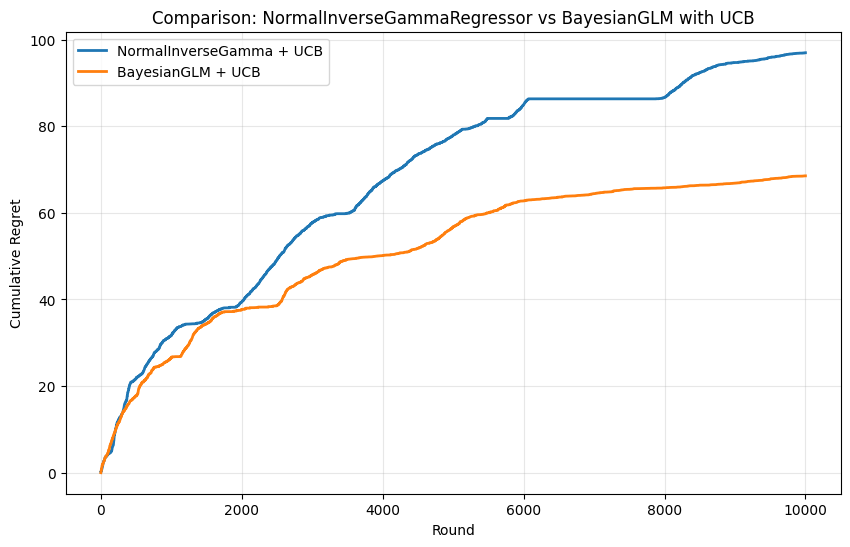

In [7]:
import matplotlib.pyplot as plt

# Calculate regrets for both approaches
normal_ucb_regret = np.cumsum(
    np.array(oracle.optimal_rewards) - np.array(oracle.expected_rewards)
)

glm_ucb_regret = np.cumsum(
    np.array(glm_ucb_oracle.optimal_rewards) - np.array(glm_ucb_oracle.expected_rewards)
)

plt.figure(figsize=(10, 6))
plt.plot(normal_ucb_regret, label="NormalInverseGamma + UCB", linewidth=2)
plt.plot(glm_ucb_regret, label="BayesianGLM + UCB", linewidth=2)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Comparison: NormalInverseGammaRegressor vs BayesianGLM with UCB")
plt.legend()
plt.grid(True, alpha=0.3)

## Comparing Thompson Sampling Approaches

`upper_confidence_bound` is not guaranteed to do well, and can often involve fine-tuning the `alpha` parameter. Instead, we may want to use the `thompson_sampling` policy, which does not require any tuning. Let's compare both approaches with Thompson sampling as well.

In [8]:
from bayesianbandits import ThompsonSampling

# Create oracles for Thompson sampling experiments
normal_thompson_oracle = ClickthroughOracle()
glm_thompson_oracle = ClickthroughOracle()

# NormalInverseGammaRegressor with Thompson Sampling
normal_thompson_agent = ContextualAgent(
    arms=[
        Arm(Article.article_1, learner=NormalInverseGammaRegressor(lam=10.0)),
        Arm(Article.article_2, learner=NormalInverseGammaRegressor(lam=10.0)),
        Arm(Article.article_3, learner=NormalInverseGammaRegressor(lam=10.0)),
        Arm(Article.article_4, learner=NormalInverseGammaRegressor(lam=10.0)),
    ],
    policy=ThompsonSampling(),
    random_seed=rng,
)

# BayesianGLM with Thompson Sampling
glm_thompson_agent = ContextualAgent(
    arms=glm_arms_thompson,
    policy=ThompsonSampling(),
    random_seed=rng,
)

Much as we did with the UCB algorithm, we'll run both bandits for 10000 iterations, and plot the cumulative regret over time.

In [9]:
# Run NormalInverseGammaRegressor with Thompson Sampling

for _ in range(10000):
    user_gender = rng.binomial(1, 0.5) # 0 corresponds to female
    user_age = rng.integers(0, 47) # 0 corresponds to age 18

    context = np.array([1.0, user_age, user_gender])

    normal_thompson_oracle.set_context(context)
    normal_thompson_oracle.best_expected_reward()

    action, = normal_thompson_agent.pull(np.atleast_2d(context))
    action.take_action(normal_thompson_oracle)
    normal_thompson_agent.update(np.atleast_2d(context), np.array([normal_thompson_oracle.rewards[-1] - 0.5]))

# Run BayesianGLM with Thompson Sampling

for _ in range(10000):
    user_gender = rng.binomial(1, 0.5) # 0 corresponds to female
    user_age = rng.integers(0, 47) # 0 corresponds to age 18

    context = np.array([1.0, user_age, user_gender])

    glm_thompson_oracle.set_context(context)
    glm_thompson_oracle.best_expected_reward()

    action, = glm_thompson_agent.pull(np.atleast_2d(context))
    action.take_action(glm_thompson_oracle)
    glm_thompson_agent.update(np.atleast_2d(context), np.array([glm_thompson_oracle.rewards[-1]]))

## Comprehensive Comparison

We can see that both approaches achieve sublinear regret, but with some interesting differences. Let's compare all four combinations:

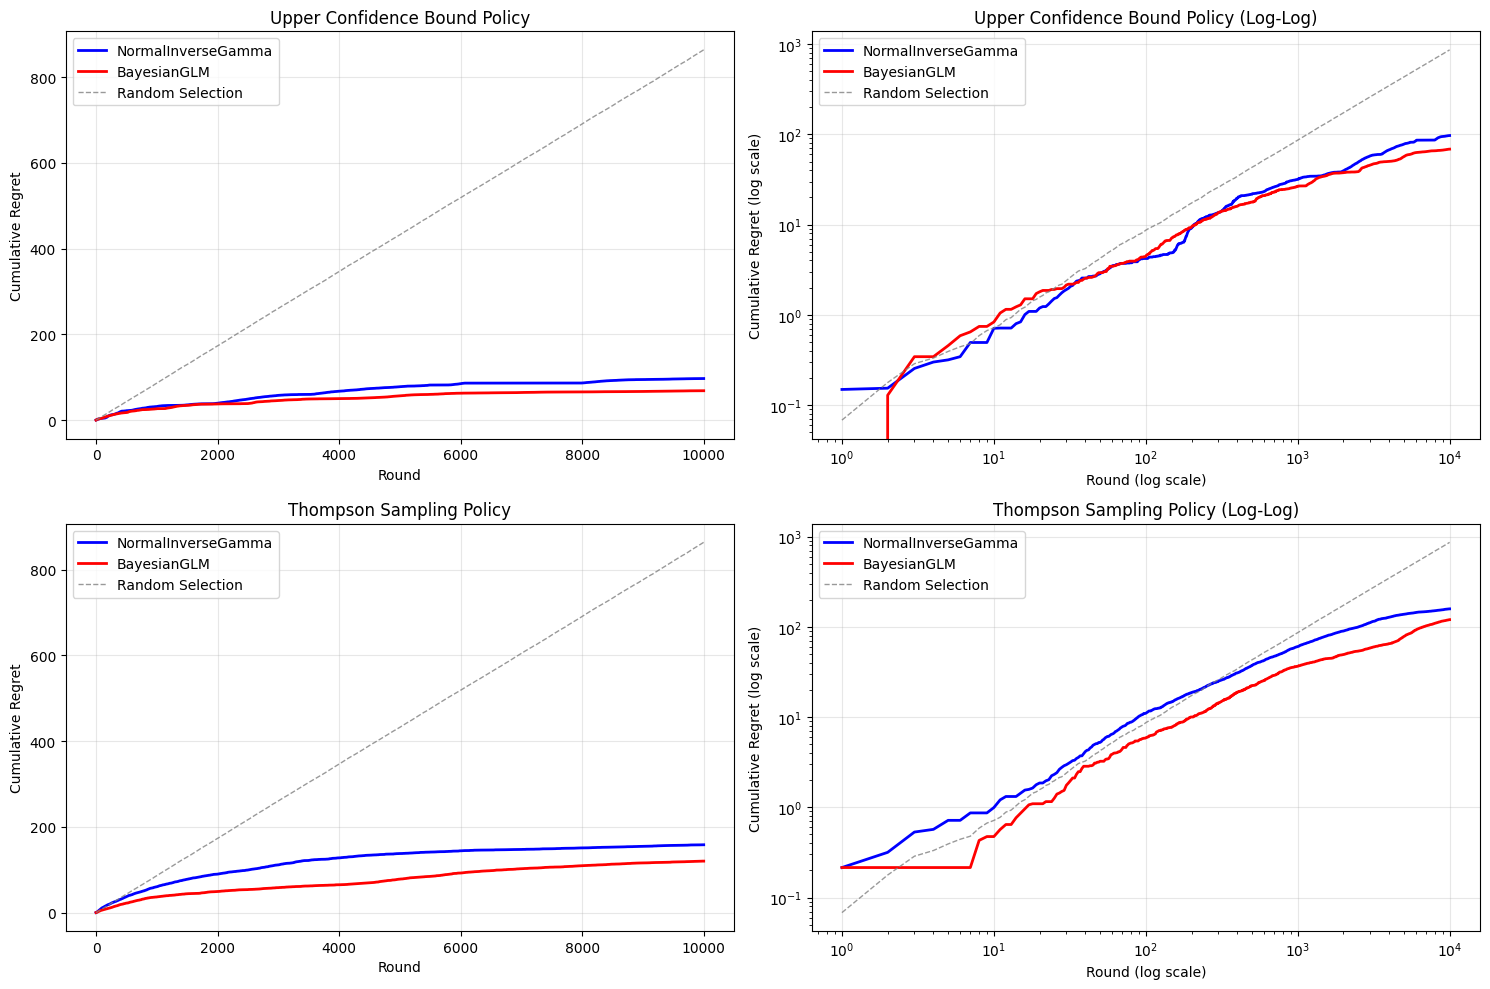

Final Regret Results (10000 rounds):
UCB - NormalInverseGamma: 96.96
UCB - BayesianGLM: 68.53
Thompson - NormalInverseGamma: 158.30
Thompson - BayesianGLM: 120.15
Random selection (linear): 863.73

Regret rates (final_regret/rounds):
UCB - NormalInverseGamma: 0.0097
UCB - BayesianGLM: 0.0069
Thompson - NormalInverseGamma: 0.0158
Thompson - BayesianGLM: 0.0120
Random selection: 0.0864


In [11]:
# Calculate regrets for all approaches
normal_thompson_regret = np.cumsum(
    np.array(normal_thompson_oracle.optimal_rewards) - np.array(normal_thompson_oracle.expected_rewards)
)

glm_thompson_regret = np.cumsum(
    np.array(glm_thompson_oracle.optimal_rewards) - np.array(glm_thompson_oracle.expected_rewards)
)

# Calculate proper linear regret baseline: random arm selection
# Recreate the context sequence and calculate true baseline
np.random.seed(123)  # Reset to get same context sequence
rng_baseline = np.random.default_rng(123)

article_coefs = np.array([
    [-0.4, 0.005, 0.1],
    [-0.8, 0.0, 0.0], 
    [-0.3, -0.005, 0.0],
    [0.1, 0.0, -0.5],
])

optimal_rewards_baseline = []
random_expected_rewards = []

for _ in range(10000):
    user_gender = rng_baseline.binomial(1, 0.5)
    user_age = rng_baseline.integers(0, 47)
    context = np.array([1.0, user_age, user_gender])
    
    # Calculate expected rewards for all arms for this context
    all_arm_rewards = expit(np.dot(context, article_coefs.T))
    
    # Optimal reward
    optimal_reward = np.max(all_arm_rewards)
    optimal_rewards_baseline.append(optimal_reward)
    
    # Random selection: expected reward is average of all arms
    random_expected = np.mean(all_arm_rewards)
    random_expected_rewards.append(random_expected)

# Calculate cumulative regret for random baseline
random_regret = np.cumsum(np.array(optimal_rewards_baseline) - np.array(random_expected_rewards))

# Create comprehensive comparison plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

rounds = np.arange(1, len(normal_ucb_regret) + 1)

# UCB Policy - Linear scale
ax1.plot(normal_ucb_regret, label="NormalInverseGamma", linewidth=2, color='blue')
ax1.plot(glm_ucb_regret, label="BayesianGLM", linewidth=2, color='red')
ax1.plot(random_regret, label="Random Selection", linewidth=1, color='gray', linestyle='--', alpha=0.8)
ax1.set_xlabel("Round")
ax1.set_ylabel("Cumulative Regret")
ax1.set_title("Upper Confidence Bound Policy")
ax1.legend()
ax1.grid(True, alpha=0.3)

# UCB Policy - Log-log scale  
ax2.loglog(rounds, normal_ucb_regret, label="NormalInverseGamma", linewidth=2, color='blue')
ax2.loglog(rounds, glm_ucb_regret, label="BayesianGLM", linewidth=2, color='red')
ax2.loglog(rounds, random_regret, label="Random Selection", linewidth=1, color='gray', linestyle='--', alpha=0.8)
ax2.set_xlabel("Round (log scale)")
ax2.set_ylabel("Cumulative Regret (log scale)")
ax2.set_title("Upper Confidence Bound Policy (Log-Log)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Thompson Sampling - Linear scale
ax3.plot(normal_thompson_regret, label="NormalInverseGamma", linewidth=2, color='blue')
ax3.plot(glm_thompson_regret, label="BayesianGLM", linewidth=2, color='red')
ax3.plot(random_regret, label="Random Selection", linewidth=1, color='gray', linestyle='--', alpha=0.8)
ax3.set_xlabel("Round")
ax3.set_ylabel("Cumulative Regret")
ax3.set_title("Thompson Sampling Policy")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Thompson Sampling - Log-log scale
ax4.loglog(rounds, normal_thompson_regret, label="NormalInverseGamma", linewidth=2, color='blue')
ax4.loglog(rounds, glm_thompson_regret, label="BayesianGLM", linewidth=2, color='red')
ax4.loglog(rounds, random_regret, label="Random Selection", linewidth=1, color='gray', linestyle='--', alpha=0.8)
ax4.set_xlabel("Round (log scale)")
ax4.set_ylabel("Cumulative Regret (log scale)")
ax4.set_title("Thompson Sampling Policy (Log-Log)")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final regret values for analysis
print("Final Regret Results (10000 rounds):")
print(f"UCB - NormalInverseGamma: {normal_ucb_regret[-1]:.2f}")
print(f"UCB - BayesianGLM: {glm_ucb_regret[-1]:.2f}")
print(f"Thompson - NormalInverseGamma: {normal_thompson_regret[-1]:.2f}")
print(f"Thompson - BayesianGLM: {glm_thompson_regret[-1]:.2f}")
print(f"Random selection (linear): {random_regret[-1]:.2f}")

# Show the regret rates to demonstrate sublinear behavior
print("\nRegret rates (final_regret/rounds):")
print(f"UCB - NormalInverseGamma: {normal_ucb_regret[-1]/10000:.4f}")
print(f"UCB - BayesianGLM: {glm_ucb_regret[-1]/10000:.4f}")
print(f"Thompson - NormalInverseGamma: {normal_thompson_regret[-1]/10000:.4f}")
print(f"Thompson - BayesianGLM: {glm_thompson_regret[-1]/10000:.4f}")
print(f"Random selection: {random_regret[-1]/10000:.4f}")

## Analysis: The Power of Misspecified Models

The experimental results illustrate why NormalInverseGammaRegressor performs well despite assuming Gaussian outcomes for binary data. Two factors combine here: the Bernstein-von Mises theorem and the fact that contextual bandits seek to model the **mean reward** E[Y|X], not individual outcomes.

Even though individual clicks are binary, the conditional expectation E[Y|X] = p(click|context) is continuous and bounded in [0,1]. NormalInverseGammaRegressor's Gaussian assumption is therefore less egregious than it initially appears—it's modeling a continuous quantity (the click probability) rather than discrete outcomes. The model misspecification manifests primarily in the variance structure, not the mean function.

The Bernstein-von Mises theorem ensures that as data accumulates, the posterior distribution converges to a normal distribution centered at the MLE, regardless of the likelihood specification. Combined with the fact that we're estimating a continuous mean function, this explains why NormalInverseGammaRegressor's exact conjugate inference competes effectively with BayesianGLM's theoretically correct but approximately computed posterior.

In sequential decision problems, this has important implications. When the quantity of interest is a conditional expectation rather than individual outcomes, and when exact posterior computation is available through conjugacy, the benefits of computational efficiency can outweigh the costs of likelihood misspecification. The convergence guarantees of Bernstein-von Mises provide the theoretical foundation, while the continuous nature of the estimation target reduces the practical impact of the distributional mismatch.